# Diffusion Project
The objective of this project is to explore the latest developments in diffusion models. For that we will base ourselfs in training a small diffusion model to generate a single class of objects.

# 1. Setup
We will start by installing and importing all libraries as well as define some helpfull functions.

In [47]:
!pip install datasets einops

Then we import the necessary libraries

In [48]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from inspect import isfunction
from functools import partial
from einops import rearrange
from tqdm.auto import tqdm

import torch
from torch import nn, einsum
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from datasets import load_dataset



---


# 2. Data Handling

Start off with some usefull shortcuts

## 2.1 Transform
The dataset we use has two problems:
1. It consists on images (not tensors)
2. The images have an unkown size that is not consistent or the one desired

To fight these problems we define two transforms. One to go from a dataset image to a tensor, and another to reverse this process into an image we can visualize.

Notice that for this we start by resizing and croping the image to a square of equal known witdh and height. Then we convert it into a tensor and finally make it vary from [-1,1]. This last step is usefull since we want to apply a zero mean distribution noise.

In [49]:
img_size = 32

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    transforms.Lambda(lambda t: (t * 2) - 1),
])

reverse_transform = transforms.Compose([
     transforms.Lambda(lambda t: (t + 1) / 2),
     transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transforms.Lambda(lambda t: t * 255.),
     transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
     transforms.ToPILImage(),
])

## 2.2 Dataset

We start by defining a custom dataset class. This enables us to load the dataset from HuggingFace directly. We had a problem using the Trochvision dataset since the CelebA dataset is download from a Google Drive. Days where a lot of people were downloading it it would reach the Google drive quota and prevent us from downloading it more.

Given this we used the HuggingFace tool to download it instead and use a custom dataset class to load the data into a PyTorch dataloader with trasnform.



In [50]:
class ImageDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data, transform=None):
        """
        Args:
            data (huggingFace dataset): dataset from huggingface
            transform (callable, optional): Optional transform to be applied
                on a image.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        img = self.data[idx]['image']

        if self.transform:
            img = self.transform(idx)

        return img

Download data and create dataset. In ours case the dataset is already in the torchvision dataset library which makes it super easy to download.

In [51]:
# Load dataset using torchvision (drive quota can block it)
#faces_data = datasets.CelebA(root='./', split='train', transform=transform, download=False)
#faces_data = datasets.CelebA(root='./data/', split='train', transform=transform, download=True)
faces_data = datasets.ImageFolder(root='./celeba/', transform=transform)

#faces_data = load_dataset('huggan/CelebA-faces', split="train")

#faces_ds = ImageDataset(faces_data)
display(len(faces_data))

202599

Visualize a few examples of the dataset

/tmp/ipykernel_14517/1705131821.py:6: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image.resize((32*5*4, 32*2*4), Image.NEAREST)


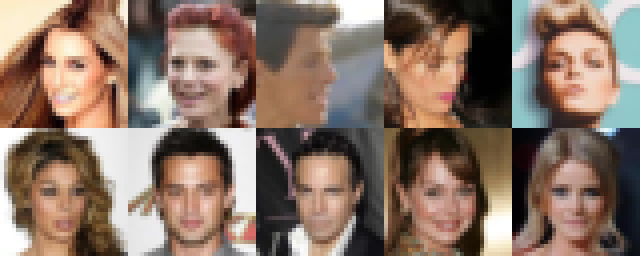

In [52]:
image = Image.new('RGB', size=(img_size*5, img_size*2))

for i in range(10):
  im = reverse_transform(faces_data[i][0])
  image.paste(im, ( (i%5)*img_size, (i//5)*img_size ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

## 2.3 Create Dataloader

In [53]:
batch_size = 128
dataloader = DataLoader(faces_data, batch_size=batch_size, shuffle=True)



---


# 3. Noise
To train the model to denoise an image we need to be able to add noise to our images

In [54]:
steps = 200

## 3.1 Beta - Forward process variances
As expressed in this [article](https://paperswithcode.com/paper/perception-prioritized-training-of-diffusion) there are multiple ways to express the "beta".

In [55]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


# define beta schedule
beta_schedule = 'linear'
if beta_schedule == 'linear':
    betas = linear_beta_schedule(timesteps=steps)
elif beta_schedule == 'cosine':
    betas = cosine_beta_schedule(timesteps=steps)
elif beta_schedule == 'quadratic':
    betas = quadratic_beta_schedule(timesteps=steps)
elif beta_schedule == 'sigmoid':
    betas = sigmoid_beta_schedule(timesteps=steps)

We will then need to define other variables such as the comulative product of the variances

In [56]:
# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

## 3.3 Add Noise Function

In [57]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.type(torch.int64).cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

Try it out

/tmp/ipykernel_14517/1633681466.py:12: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image.resize((32*5*4, 32*4), Image.NEAREST)


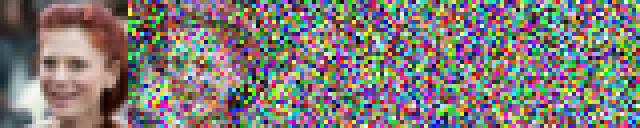

In [58]:
x = faces_data[1][0]

ims = []
for i in [0, steps/4, steps/2, steps/4*3, steps-1]:
    t = torch.tensor([i])
    x_noisy = q_sample(x, t=t)
    ims.append(reverse_transform(x_noisy))

image = Image.new('RGB', size=(img_size*5, img_size))
for i, im in enumerate(ims):
    image.paste(im, ( (i%5)*img_size, (i//5)*img_size ))
image.resize((32*5*4, 32*4), Image.NEAREST)

# 4. Model
For the denoising step we will use a U-Net

We start off defining some helpful functions and modules

In [59]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

## 4.1 Time Embedding
We then implement the position embeddings

In [60]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


## 4.2 ResNet block

In [61]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)


class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

## 4.3 Attention
We implement two methods of attention. The regular one and a linear attention method which is much more efficient both in time and memory usage.

In [62]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


## 4.4 Group Normalization

In [63]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


## 4.5 U-Net
The U-net works almost as an autoencoder. It first downsamples the input and operates on the image in the latent space before uoscaling again.

The objective of our neural network is to estimate the noise added to the original image.

I should then take a batch of noisy images as input (batch_size, n_channels, height, width) and output a tensor of equal shape with the noise.

In [64]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)


# 5. Generate Noisy Image

In [65]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, steps)), desc='sampling loop time step', total=steps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


# 6. Train

We start with some helpfull functions

In [66]:
from pathlib import Path
from datetime import datetime
import json

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid



## 6.1 Loss
We then define multiple loss functions to choose from. We will compare them and decide which gives best results

In [67]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss


## 6.2 Model creation

In [68]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

use_convnext = False

model = Unet(
    dim=img_size,
    channels=3,
    dim_mults=(1, 2, 4,),
    use_convnext = use_convnext
)
model.to(device)

Unet(
  (init_conv): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): GELU()
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=32, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(20, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ResnetBlock(
     

## Training Loop
We will define the training loop function

In [69]:
def train(model, optimizer, config):
    
    it = 0
    
    for epoch in range(config['epochs']):
        print("[Epoch: ", epoch, "]")

        for step, batch in enumerate(dataloader):
            optimizer.zero_grad()
            
            batch_size = batch[0].shape[0]
            batch = batch[0].to(device)

            # Algorithm 1 line 3: sample t uniformally for every example in the batch
            t = torch.randint(0, config['noise_steps'], (batch_size,), device=config['device']).long()

            loss = p_losses(model, batch, t, loss_type=config['loss_type'])

            it += 1
            if step % 100 == 0:
                print("Loss:", loss.item())

            loss.backward()
            optimizer.step()


        # Visualize state after each epoch  
        with torch.no_grad():  
            samples = sample(model, image_size=config['img_size'], batch_size=10, channels=3)

            # show a random one
            ims = [reverse_transform(samples[-1][i]) for i in range(10)]
            grid = image_grid(ims, rows=2, cols=5)
            grid = grid.save(str(results_folder / f'sample-epoch{epoch}.png'))
    
    print("Finished! ", it, " training steps completed")

In [ ]:
from torchvision.utils import save_image

epochs = 50
lr = 1e-4
optimizer = Adam(model.parameters(), lr=lr)

hyperparameters = dict(
    epochs = epochs,
    noise_steps = steps,
    batch_size = batch_size,
    img_size = img_size,
    learning_rate = lr,
    beta_schedule = beta_schedule,
    dataset = 'CelebA',
    device = device,
    use_convnext = use_convnext,
    loss_type="huber"
)

# Create folder for run
results_folder = Path("./results/imgs_" + datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
results_folder.mkdir(exist_ok = True)

# Save hyperparameters to json file
with open(str(results_folder / f'hyperparameters.json'), "w") as write_file:
    json.dump(hyperparameters, write_file, indent=4)
display(hyperparameters) 

# Train
train(model, optimizer, hyperparameters)

# Save model to results folder
torch.save(model.state_dict(), str(results_folder / './model.pth'))

{'epochs': 50,
 'noise_steps': 200,
 'batch_size': 128,
 'img_size': 32,
 'learning_rate': 0.0001,
 'beta_schedule': 'linear',
 'dataset': 'CelebA',
 'device': 'cuda',
 'use_convnext': False,
 'loss_type': 'huber'}

[Epoch:  0 ]
Loss: 0.492999792098999
Loss: 0.3125971555709839
Loss: 0.18361863493919373
Loss: 0.13646337389945984
Loss: 0.11988739669322968
Loss: 0.10243088006973267
Loss: 0.09267757833003998
Loss: 0.09358634799718857
Loss: 0.07622864842414856
Loss: 0.06915716081857681
Loss: 0.07961113005876541
Loss: 0.06895138323307037
Loss: 0.06603795289993286
Loss: 0.06600009649991989
Loss: 0.05385824292898178
Loss: 0.07111608982086182


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1 ]
Loss: 0.05587462708353996
Loss: 0.05933902785181999
Loss: 0.05738150328397751
Loss: 0.056798823177814484
Loss: 0.056439727544784546
Loss: 0.05347878858447075
Loss: 0.05831405520439148
Loss: 0.05457770824432373
Loss: 0.05985873565077782
Loss: 0.055666565895080566
Loss: 0.05119027942419052
Loss: 0.05316498875617981
Loss: 0.05260448157787323
Loss: 0.053823456168174744
Loss: 0.04840436577796936
Loss: 0.05037812516093254


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  2 ]
Loss: 0.04622950404882431
Loss: 0.05571245402097702
Loss: 0.04914584010839462
Loss: 0.044066786766052246
Loss: 0.03885859251022339
Loss: 0.06370829045772552
Loss: 0.04182270169258118
Loss: 0.05322524160146713
Loss: 0.04171086475253105
Loss: 0.043582648038864136
Loss: 0.04049929976463318
Loss: 0.04745287820696831
Loss: 0.050301432609558105
Loss: 0.048208869993686676
Loss: 0.042792510241270065
Loss: 0.039980944246053696


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  3 ]
Loss: 0.042888715863227844
Loss: 0.04144928604364395
Loss: 0.034275516867637634
Loss: 0.03826592490077019
Loss: 0.03757404908537865
Loss: 0.047401078045368195
Loss: 0.04137265309691429
Loss: 0.04220224544405937
Loss: 0.03857794404029846
Loss: 0.05207204073667526
Loss: 0.039569586515426636
Loss: 0.040067944675683975
Loss: 0.04086624085903168
Loss: 0.0418623685836792
Loss: 0.0356936901807785
Loss: 0.03795633465051651


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  4 ]
Loss: 0.034213002771139145
Loss: 0.041322533041238785
Loss: 0.03415563702583313
Loss: 0.03721075505018234
Loss: 0.045628976076841354
Loss: 0.04578140377998352
Loss: 0.03680534288287163
Loss: 0.043111853301525116
Loss: 0.049042411148548126
Loss: 0.03344924747943878
Loss: 0.03749864920973778
Loss: 0.03719373419880867
Loss: 0.03389190137386322
Loss: 0.033420078456401825
Loss: 0.04291260242462158
Loss: 0.033549100160598755


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  5 ]
Loss: 0.03370371460914612
Loss: 0.03953827917575836
Loss: 0.035650476813316345
Loss: 0.04185596853494644
Loss: 0.03999600559473038
Loss: 0.04098397120833397
Loss: 0.036356061697006226
Loss: 0.040988028049468994
Loss: 0.037214331328868866
Loss: 0.03226311504840851
Loss: 0.033520493656396866
Loss: 0.030510809272527695
Loss: 0.042559683322906494
Loss: 0.032904960215091705
Loss: 0.031482405960559845
Loss: 0.029564393684267998


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  6 ]
Loss: 0.03910107538104057
Loss: 0.03168823570013046
Loss: 0.03369779884815216
Loss: 0.037405192852020264
Loss: 0.03257650136947632
Loss: 0.0411662831902504
Loss: 0.03153528273105621
Loss: 0.02990768849849701
Loss: 0.03228328004479408
Loss: 0.02974379062652588
Loss: 0.03137023746967316
Loss: 0.03126496449112892
Loss: 0.03876145929098129
Loss: 0.037170346826314926
Loss: 0.039818573743104935
Loss: 0.03179410099983215


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  7 ]
Loss: 0.03302513808012009
Loss: 0.039097677916288376
Loss: 0.041551798582077026
Loss: 0.03942235931754112
Loss: 0.02608368545770645
Loss: 0.033814117312431335
Loss: 0.032627176493406296
Loss: 0.04227922111749649
Loss: 0.03638163208961487
Loss: 0.03329925239086151
Loss: 0.03288405388593674
Loss: 0.028322098776698112
Loss: 0.03520959988236427
Loss: 0.034395307302474976
Loss: 0.03564566746354103
Loss: 0.03452295809984207


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  8 ]
Loss: 0.037354450672864914
Loss: 0.04065537452697754
Loss: 0.025410648435354233
Loss: 0.03472507745027542
Loss: 0.040536463260650635
Loss: 0.028973281383514404
Loss: 0.035072628408670425
Loss: 0.03417282551527023
Loss: 0.031375590711832047
Loss: 0.0270460844039917
Loss: 0.032590750604867935
Loss: 0.02951333485543728
Loss: 0.030402909964323044
Loss: 0.030306508764624596
Loss: 0.03719062730669975
Loss: 0.0310077928006649


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  9 ]
Loss: 0.02814333513379097
Loss: 0.02794669382274151
Loss: 0.03377365693449974
Loss: 0.0332072377204895
Loss: 0.03361247479915619
Loss: 0.029631799086928368
Loss: 0.03467816859483719
Loss: 0.03507073223590851
Loss: 0.029634084552526474
Loss: 0.029041117057204247
Loss: 0.031383976340293884
Loss: 0.03559255599975586
Loss: 0.03324652090668678
Loss: 0.033079516142606735
Loss: 0.029165765270590782
Loss: 0.033434849232435226


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  10 ]
Loss: 0.030966326594352722
Loss: 0.03565663844347
Loss: 0.040534645318984985
Loss: 0.03325639292597771
Loss: 0.03468463197350502
Loss: 0.041082777082920074
Loss: 0.031672608107328415
Loss: 0.036304667592048645
Loss: 0.03297542780637741
Loss: 0.027085652574896812
Loss: 0.029111821204423904
Loss: 0.03318238630890846
Loss: 0.03340039402246475
Loss: 0.033579036593437195
Loss: 0.03818975389003754
Loss: 0.034985266625881195


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  11 ]
Loss: 0.03420855849981308
Loss: 0.03180614113807678
Loss: 0.02923118881881237
Loss: 0.04069078713655472
Loss: 0.030133571475744247
Loss: 0.03690316900610924
Loss: 0.03767233341932297
Loss: 0.026253409683704376
Loss: 0.02927173674106598
Loss: 0.036359988152980804
Loss: 0.03888537734746933
Loss: 0.030379129573702812
Loss: 0.03344089537858963
Loss: 0.03405977413058281
Loss: 0.04065204784274101
Loss: 0.037965282797813416


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  12 ]
Loss: 0.027639511972665787
Loss: 0.03262786567211151
Loss: 0.0316472202539444
Loss: 0.03453810140490532
Loss: 0.026405028998851776
Loss: 0.03153306245803833
Loss: 0.030661311000585556
Loss: 0.03386388346552849
Loss: 0.030249666422605515
Loss: 0.03257549926638603
Loss: 0.030939143151044846
Loss: 0.03977612406015396
Loss: 0.03530101478099823
Loss: 0.030460050329566002
Loss: 0.035352230072021484
Loss: 0.029655691236257553


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  13 ]
Loss: 0.0251278355717659
Loss: 0.0316007062792778
Loss: 0.04104849323630333
Loss: 0.027833130210638046
Loss: 0.03409386798739433
Loss: 0.031547028571367264
Loss: 0.027313580736517906
Loss: 0.031812503933906555
Loss: 0.027269272133708
Loss: 0.03230656310915947
Loss: 0.03490125760436058
Loss: 0.030625447630882263
Loss: 0.024518607184290886
Loss: 0.03200293332338333
Loss: 0.027367938309907913


In [ ]:
samples = sample(model, image_size=img_size, batch_size=10, channels=3)

# show a random one
ims = [reverse_transform(samples[-1][i]) for i in range(10)]
grid = image_grid(ims, rows=2, cols=5)

image = Image.new('RGB', size=(img_size*5, img_size*2))
image.paste(grid, ( 0, 0, img_size*5, img_size*2))
image.resize((32*4*5, 32*4*2), Image.NEAREST)

In [ ]:
samples = sample(model, image_size=img_size, batch_size=1, channels=3)

# show a random one
ims = [reverse_transform(samples[i][0]) for i in range(steps)]

ims[0].save(str(results_folder / 'animation.gif'), format='GIF',
               append_images=ims[1:], save_all=True, duration=10, loop=0)